In [2]:
import numpy as np 
import os
from cv2 import *
import skimage.io as io
import skimage.transform as trans
import numpy as np
import matplotlib.pyplot as plt
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import tensorflow as tf
%matplotlib inline

In [3]:
path_y_train = "data/y_train/"
path_x_train = "data/x_train/"
path_x_test = "data/x_test/"
path_y_test = "data/y_test/"

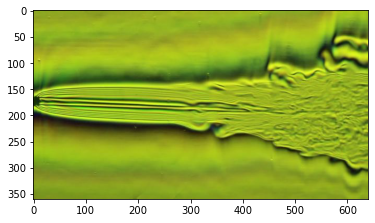

In [3]:
img = plt.imread(path_x_train + 'MVI_1333 1081.jpg')
plt.imshow(img)

In [4]:
image_names_train = sorted(os.listdir(path_x_train))
image_names_train_detect = sorted(os.listdir(path_y_train))
image_names_test = sorted(os.listdir(path_x_test))
image_names_test_y = sorted(os.listdir(path_y_test))

In [5]:
y_train_list = []
x_train_list = []
x_test_list = []
y_test_list = []
for name in image_names_train_detect:
    image = cv2.imdecode(np.fromfile(path_y_train + name, dtype=np.uint8), 0)
    #image = plt.imread(path_train_detect + name)
    y_train_list.append(cv2.resize(image,(256,256)))
    
for name in image_names_train:
    #image = cv2.imdecode(np.fromfile(path_train + name, dtype=np.uint8), 0)
    image = plt.imread(path_x_train + name)
    x_train_list.append(cv2.resize(image,(256,256)))
    
for name in image_names_test:
    #image = cv2.imdecode(np.fromfile(path_test + name, dtype=np.uint8), 0)
    image = plt.imread(path_x_test + name)
    x_test_list.append(cv2.resize(image,(256,256)))
    
for name in image_names_test_y:
    image = cv2.imdecode(np.fromfile(path_y_test + name, dtype=np.uint8), 0)
    #image = plt.imread(path_test_y + name)
    y_test_list.append(cv2.resize(image,(256,256)))

In [6]:
y_train = np.array(y_train_list)
x_train = np.array(x_train_list)
x_test = np.array(x_test_list)
y_test = np.array(y_test_list)

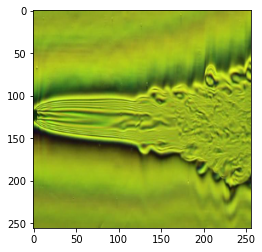

In [7]:
plt.imshow(x_test[5])

In [7]:
x_test = x_test / 255.
x_train = x_train / 255.

In [8]:
y_train = (y_train > 0.5).astype(np.float32)
y_test = (y_test > 0.5).astype(np.float32)

In [11]:
y_train.shape

(40, 256, 256)

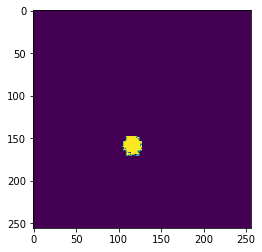

In [50]:
plt.imshow(y_test[0])

In [9]:
def create_weighted_binary_crossentropy(zero_weight, one_weight):

    def weighted_binary_crossentropy(y_true, y_pred):

        # Original binary crossentropy (see losses.py):
        # K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

        # Calculate the binary crossentropy
        b_ce = keras.binary_crossentropy(y_true, y_pred)

        # Apply the weights
        weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce

        # Return the mean error
        return keras.mean(weighted_b_ce)

    return weighted_binary_crossentropy

In [18]:
def weighted_binary_crossentropy(y_true, y_pred):

        # Original binary crossentropy (see losses.py):
        # K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

        # Calculate the binary crossentropy
        b_ce = keras.binary_crossentropy(y_true, y_pred)

        # Apply the weights
        weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce

        # Return the mean error
        return keras.mean(weighted_b_ce)

In [10]:
def unet(pretrained_weights = None,input_size = (256,256,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    #model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    model.compile(optimizer=Adam(lr = 1e-4), loss=create_weighted_binary_crossentropy(0.01, 0.99), metrics=['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [11]:
model = unet()

In [19]:
model = load_model('UnetModel.h5',custom_objects={'weighted_binary_crossentropy' : weighted_binary_crossentropy})

In [21]:
#history = model.fit(x_train, y_train, batch_size=8, epochs = 10)

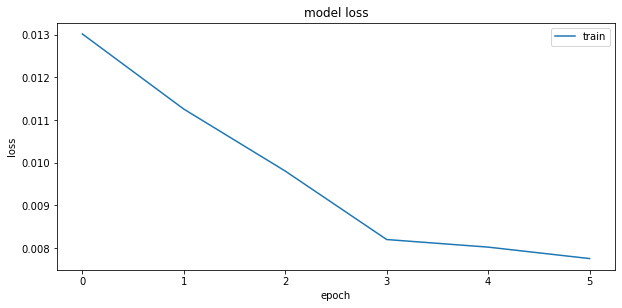

In [52]:
plt.figure(figsize=(10, 10))
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train'], loc='upper left')  
   
plt.subplot(212)  
plt.plot(history.history['loss']) 
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train'], loc='upper right')  
plt.show()  

In [43]:
print(history.history.keys())  

dict_keys(['loss', 'accuracy'])


In [22]:
pred = model.predict(x_test)

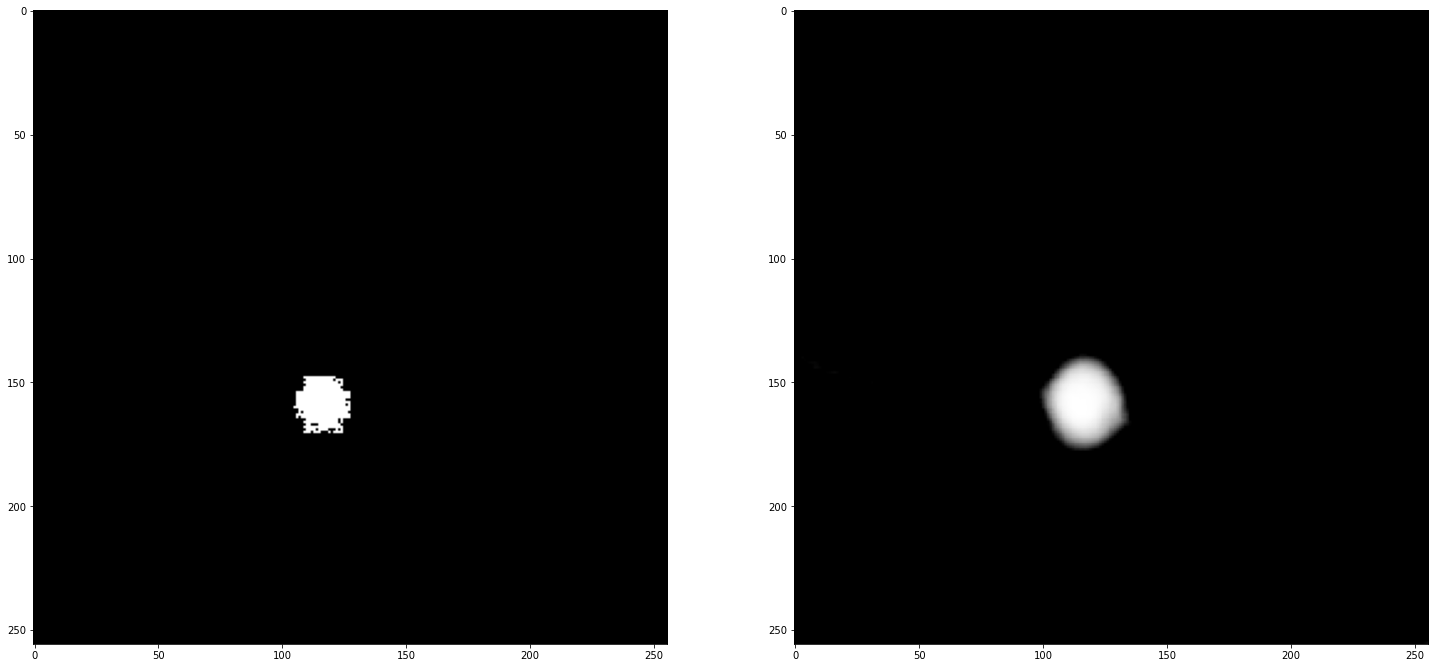

In [27]:
im_id = 0
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(y_test[im_id], cmap = 'gray')
im = axes[1].imshow(pred[im_id,...,0], cmap = 'gray')
#fig.colorbar(im,ax = axes[1])
plt.show()

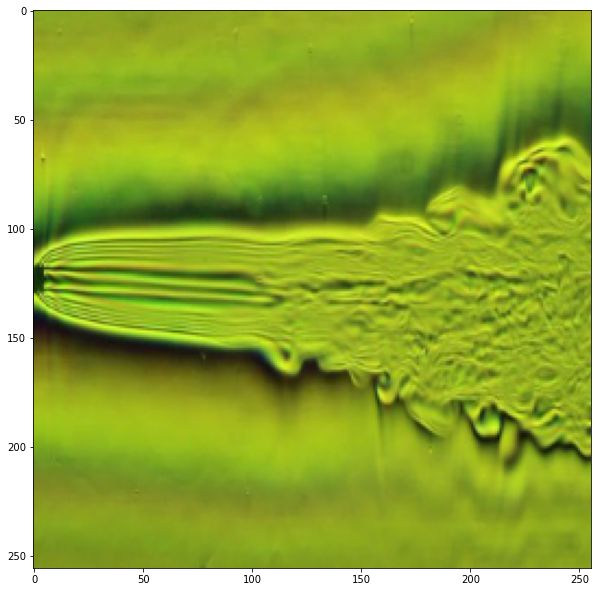

In [28]:
im_id = 4
plt.figure(figsize=(10, 25))
plt.imshow(x_test[im_id], cmap = 'gray')
plt.show()

In [29]:
#oss,accuracy = model.evaluate(x_test,y_test,verbose = 1)

In [33]:
model.save('UnetModel.h5')